In [12]:
from typing import Dict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plot import plot_hbar_groups

In [20]:
vulns_df = pd.read_csv(os.path.join("data", "out", "vulns.csv"))
comps_df = pd.read_csv(os.path.join("data", "out", "components.csv"))
meta_df = pd.read_csv(os.path.join("data", "out", "metadata.csv"))

JOIN_COL = ["registry_domain", "registry_path", "image_name", "image_tag"]

In [21]:
def format_df(df: pd.DataFrame, column: str) -> Dict:
    types = df["report_type"].unique()
    ids = df["compare_id"].unique()
    members = {t: [] for t in types}

    for t in members.keys():
        for id in ids:
            tmask = df["report_type"] == t
            imask = df["compare_id"] == id
            filtered = df[tmask & imask][column]
            if filtered.shape[0] == 0:
                val = 0
            else:
                val = filtered.iloc[0]
            members[t].append(val)
    
    return members, ids

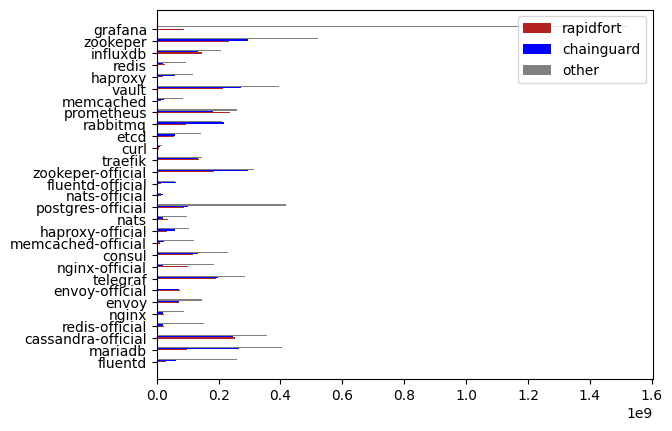

In [23]:
# Image size by registry

img_sz_df = meta_df.drop(["registry_domain",
                          "registry_path",
                          "image_tag"], axis=1)

members, groups = format_df(img_sz_df, "image_size")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}
fig, ax = plt.subplots()

plot_hbar_groups(ax, members, groups, colors)

In [ ]:
# TODO
# Number of components by registry

In [ ]:
# TODO
# Number of vulns by registry

In [ ]:
# TODO
# Vulns per MB by registry

In [ ]:
# TODO
# Vulns per component by registry